In [77]:

from qiskit import ClassicalRegister, QuantumRegister,QuantumCircuit,transpile, execute,BasicAer
from numpy import pi
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import Parameter
import numpy as np
from qiskit.tools.visualization import circuit_drawer,plot_histogram
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
theta_range = np.linspace(0,  np.pi, 40)

theta = Parameter('θ')




In [78]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

/usr/local/lib/python3.8/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


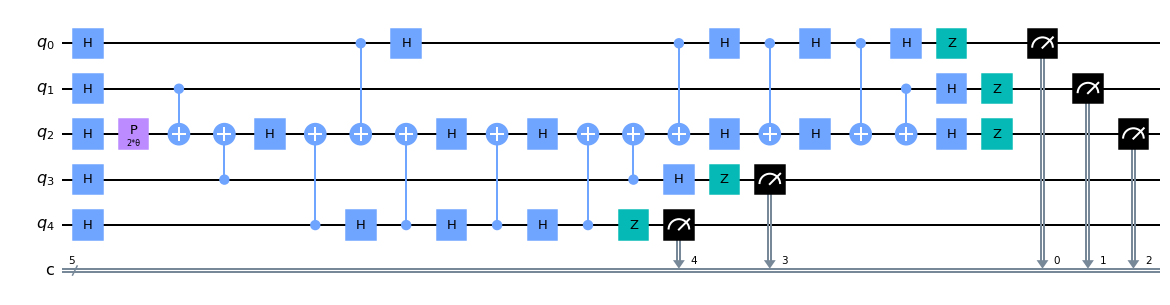

In [79]:
qsize = 5
qreg_q = QuantumRegister(5, 'q')
creg_c = ClassicalRegister(5, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.h(qreg_q[2])
circuit.h(qreg_q[3])
circuit.h(qreg_q[4])
circuit.p(2*theta, qreg_q[2])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[2])
circuit.h(qreg_q[2])
circuit.cx(qreg_q[4], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[4])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[4], qreg_q[2])
circuit.h(qreg_q[2])
circuit.h(qreg_q[4])
circuit.cx(qreg_q[4], qreg_q[2])
circuit.h(qreg_q[2])
circuit.h(qreg_q[4])
circuit.cx(qreg_q[4], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[2])
circuit.z(qreg_q[4])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[3])
circuit.h(qreg_q[0])
circuit.h(qreg_q[2])
circuit.z(qreg_q[3])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[0])
circuit.h(qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.h(qreg_q[0])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.z(qreg_q[0])
circuit.h(qreg_q[1])
circuit.h(qreg_q[2])
circuit.z(qreg_q[1])
circuit.z(qreg_q[2])

measure = [0,1,2,3,4]
for i in measure:
    circuit.measure(qreg_q[i], creg_c[i])
circuit.draw(output='mpl')



In [80]:


#bind the parameters

circuits = [circuit.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

#シミュレーターの指定, select the simulator
simulator = AerSimulator(noise_model=noise_bit_flip)
#量子回路のシミュレーターを使った実行, run the circuit for all the theta values
job = simulator.run(transpile(circuits, simulator),shots= 8192)
#測定結果の取り出し
# Run and get counts

result = job.result()
counts = result.get_counts()



In [86]:
def correctRabi(counts):
    encoded_counts=[]
    correct_counts = []
    for dic in counts:
        answer =0
        answer_en=0
        answer_size=0
        val = list(dic.values())
        keys= list(dic.keys())
# Obtain the parity of K5
        for i in range(len(val)):
            L = [int(j)for j in keys[i] ]
            if (L[2] +L[3])%2 ==0:
                answer_en+= val[i]
# Postselect according to the parity of K1 and K2
            if(L[0]+L[3]+L[4])%2==0 & (L[0]+L[1]+L[2])%2==0:
                    answer_size+= val[i]
                    if (L[2] +L[3])%2 ==0:
                        answer+= val[i]
        correct_counts.append(answer/answer_size)
        encoded_counts.append(answer_en)
    return np.array(encoded_counts)/8192, np.array(correct_counts)



In [82]:
EncodedCounts, CorrectCounts = correctRabi(counts)


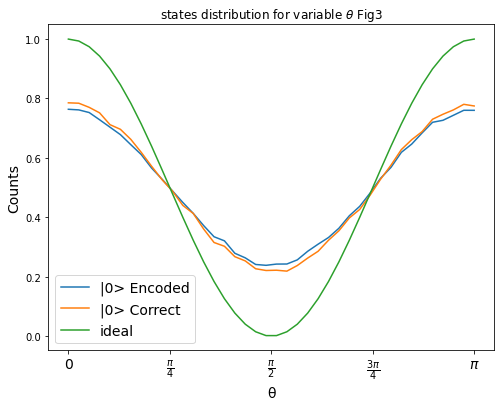

In [87]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
#ax.plot(theta_range, list(map(lambda c: (1/8192)*(c.get('00000',1)+c.get('01111',1)+c.get('10101',1)+c.get('11000',1) ), counts)), '.-', label='|0>')
ax.plot(theta_range, EncodedCounts, label='|0> Encoded') 
ax.plot(theta_range, CorrectCounts, label='|0> Correct') 
ax.plot(theta_range, np.cos(theta_range)**2, label ="ideal")
ax.set_xticks([i * np.pi/4 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('states distribution for variable '+r'$\theta$'+" Fig3")
ax.legend(fontsize=14)

In [84]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
KEY = "dbb63abf5cae34045d60c50e94eedd65ab328a642e2eaa27a88fa32bb2da41d05c59859204625ab690d988f286a4e06cfca28d06f4a555056513517ff3f9d429"
IBMQ.save_account(KEY, overwrite=True)


In [85]:
provider =IBMQ.load_account() # Load account from disk


ibmqfactory.load_account:WARNING:2021-12-12 16:30:49,001: Credentials are already in use. The existing account in the session will be replaced.
